In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import statsmodels.api as sm

In [2]:
from matfusion_jax import vis, data

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

# Load Results

Specify the directories to load results from after running `eval.py` and `score.py`.

In [6]:
results_dirs = {
    'flash': Path('./results/print_flash/test_rasterized/'),
}

In [17]:
ERROR_TYPES = [
    'rmse_diffuse_error',
    'rmse_specular_error',
    'rmse_roughness_error',
    'rmse_normals_error',
    'lpips_albedo_error',
    'l1_rerender_error',
    'lpips_rerender_error',
    'lpips_dome_error',
]
results = pd.DataFrame({
    'dir': pd.Series(dtype=str),
    'name': pd.Series(dtype=str),
    'replicate': pd.Series(dtype=int),
    **{ n: pd.Series(dtype=float) for n in ERROR_TYPES },
})
results_pbar = IntProgress(min=0, max=sum(len(list(d.iterdir())) for d in results_dirs.values()))
display(results_pbar)
for (dirname, d) in results_dirs.items():
    true_loader = data.Loader(d / 'eval_dataset.yml')
    est_loader = true_loader.with_svbrdfs(d)
    for r in d.iterdir():
        results_pbar.value += 1
        try:
            rid = json.loads((r / 'result_id.json').read_text())
        except IOError or FileNotFoundError:
            continue
        row = { 'dir': dirname, 'name': rid['name'], 'replicate': rid['replicate'] }
        for error_ty in ERROR_TYPES:
            try:
                row[error_ty] = float(est_loader.metadata_path(rid, error_ty).read_text())
            except FileNotFoundError:
                pass
        results.loc[len(results)] = row

IntProgress(value=0, max=1008)

# Perform Selection

Most SVBRDF estimation techniques deterministically produce a single "best" SVBRDF which has minimized error. But MatFusion generates random samples from the conditional distribution of SVBRDFs. We have to somehow produce a most likely estimate from that distribution. As described in the paper, we can either

1. Use a fixed seed so that a single random sample is considered our "best" estimate
2. Sample 10 SVBRDFs and pick the one which rerenders most like the input image (minimizing lpips_rerender_error)

In [18]:
replicate_groups = results.groupby(['dir', 'name'], as_index=False)
fixed_seed_results = replicate_groups.apply(lambda g: g.loc[g['replicate'] == 0])
automatic_results = replicate_groups.apply(lambda g: g.iloc[g['lpips_rerender_error'].argmin()])

# Mean Error Numbers

In [19]:
fixed_seed_results.drop(columns=['replicate']).groupby('dir').mean().T

dir,v1,v2
rmse_diffuse_error,0.037329,0.046173
rmse_specular_error,0.079904,0.069670
rmse_roughness_error,0.115142,0.111924
rmse_normals_error,0.056152,0.053686
lpips_albedo_error,0.300793,0.303001
l1_rerender_error,0.021974,0.036892
lpips_rerender_error,0.093149,0.172049
lpips_dome_error,0.214226,0.222676


In [20]:
automatic_results.drop(columns=['replicate']).groupby('dir').mean().T

dir,v1,v2
rmse_diffuse_error,0.038344,0.045074
rmse_specular_error,0.076174,0.066507
rmse_roughness_error,0.121223,0.118269
rmse_normals_error,0.054653,0.053639
lpips_albedo_error,0.301364,0.288428
l1_rerender_error,0.019246,0.033520
lpips_rerender_error,0.067896,0.145941
lpips_dome_error,0.204696,0.210894


# Visulize Results

Thanks to ChatGPT for knowing how to use PyPlot better than I do.

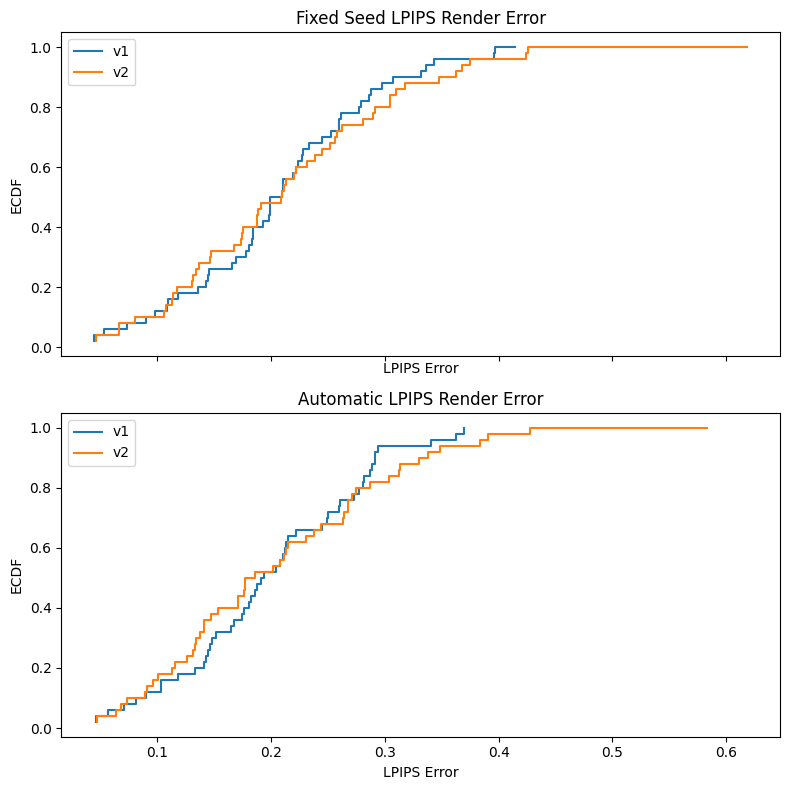

In [21]:
df_dict = { 'Fixed Seed': fixed_seed_results, 'Automatic': automatic_results }

# Create subplots
num_subplots = len(df_dict)
fig, axes = plt.subplots(nrows=num_subplots, ncols=1, figsize=(8, 4*num_subplots), sharex=True)

# Plot ECDF for each 'dir' in each dataframe
for (axis, (t, df)) in zip(axes, df_dict.items()):
    unique_dirs = df['dir'].unique()
    for dir_value in unique_dirs:
        subset = df[df['dir'] == dir_value]['lpips_dome_error']
        ecdf = sm.distributions.ECDF(subset)
        x = sorted(subset)
        y = ecdf(x)
        axis.step(x, y, label=dir_value)

    axis.set_title(f'{t} LPIPS Render Error')
    axis.legend()
    axis.set_xlabel('LPIPS Error')
    axis.set_ylabel('ECDF')

plt.tight_layout()
plt.show()